# Tutorial Part 1: Reading in AIM files

Author: *Dr. Danielle Whittier and Jilmen Quintiens*
<br>Created: *17 Jan 2024*
<br>Last Modified: *17 Jan 2024*

## Load necessary packages
vtkbone is the core tool used here for reading and writing .AIMs

In [10]:
import numpy as np
import vtk
import vtkbone
import SimpleITK as sitk
import matplotlib.pyplot as plt

In addition we will import some helper functions. These are found in the "/python_helpers" sub-folder and originally pulled from the Bone Lab Repositoty. 

The purpose of each is described in the code comments below:

In [2]:
#provides function to read AIM header (in standard format) and pull key values for density calibration
from python_helpers.aim_calibration_header import get_aim_calibration_constants_from_processing_log
from python_helpers.aim_calibration_header import get_aim_density_equation
from python_helpers.aim_calibration_header import get_aim_hu_equation

#provides functions for converting between vtk image data format to a numpy array and back
from python_helpers.vtk_util import vtkImageData_to_numpy, numpy_to_vtkImageData


## Read in AIM file

This step uses the vtkboneAIMReader() class from vtkbone. The details of this class, including a list of all member functions can be found in the documentation [here](https://www.numerics88.com/documentation/vtkbone/1.0/classvtkboneAIMReader.html)

In [3]:
#specify file path to image. here we use the example image found in the "/data" subfolder
file_path = "data/TRAB_1240.AIM"

# read in aim image
reader = vtkbone.vtkboneAIMReader()
reader.DataOnCellsOff() 
reader.SetFileName(file_path)
reader.Update()

#here we pull the image data itself along with the header information 
img_file = reader.GetOutput()
img_header = reader.GetProcessingLog()

## Convert to numpy array
This uses the helper function that we loaded at the beginning of the notebook:

In [4]:
np_image = vtkImageData_to_numpy(img_file)

#printing out a few checks to show the data dimensions are the same, but the data format is different 
print("Dimensions of vtk image: ", img_file.GetDimensions())
print("Dimensionts of np image array: ", np.shape(np_image))

Dimensions of vtk image:  (108, 108, 126)
Dimensionts of np image array:  (108, 108, 126)


We can even do a basic visualization with matlibplot:

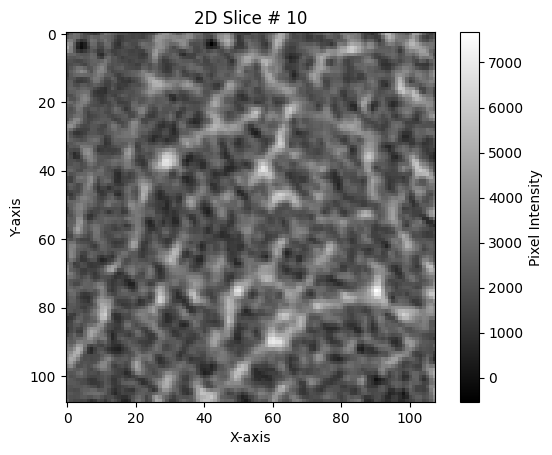

In [6]:
# Select the slice you want to visualize (you can change the index)
slice_index = 10
selected_slice = np_image[:, :, slice_index]

# Set labels and title
# Plot the slice using matplotlib
plt.imshow(selected_slice, cmap='gray')
plt.title(f"2D Slice # {slice_index}")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Pixel Intensity")
plt.show()

# Show the plot
plt.show()

## Convert image units
From the plot you'll notice the image units are not meaningful. This is because they are in native Scanco units. We can convert the units to density (mg HA/ccm), linear attenuation (1/mm), or Hounsfield Units (unitless) so that they are more meaningful to work with.

This can be done with the helper functions. In all cases these helper functions assume the header is formatted in the standard Scanco manner. 

### Convert to Linear Attenuation

For linear attenuation we need the mu scaling constant. Where linear attenuation (mu) is obtained from the native units in the following format:
<br>
<br>
$$
\text{mu} = \text{Native} \times \text{mu_scaling}
$$


In [9]:
#first get the image calibration information from the image header with the helper function. 
mu_scaling, hu_mu_water, hu_mu_air, dens_slope, dens_int = get_aim_calibration_constants_from_processing_log(img_header)

#scale to linear attenuation with mu scaling value
np_image_lin_atten = np_image/mu_scaling

#print some outputs to show that it is changed
print("Image converted to linear attenuation")
print("Raw image data mean: ", np.mean(np_image), "[native]")
print("converted image data mean in linear attenuation: ", np.mean(np_image_lin_atten), "[1/cm]")

Image converted to linear attenuation
Raw image data mean:  2492.4075264822436 [native]
converted image data mean in linear attenuation:  0.3042489656350395 [1/cm]


Here is a simple visualization to show the image is the same, but values scaled

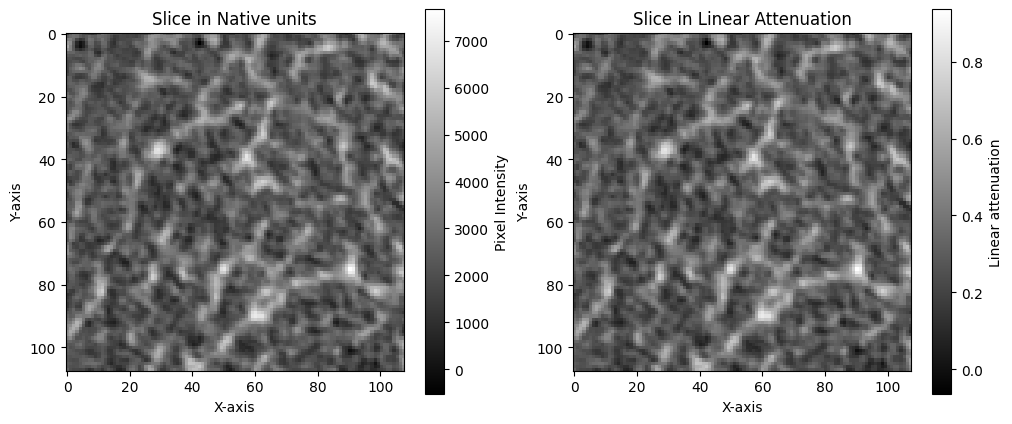

In [20]:
# Select the slice you want to visualize (you can change the index)
slice_index = 10
native_slice = np_image[:, :, slice_index]
lin_atten_slice = np_image_lin_atten[:, :, slice_index]

# Plot the slices side by side using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Set labels and title
# Plot the slice using matplotlib
im1 = axs[0].imshow(native_slice, cmap='gray')
axs[0].set_title("Slice in Native units")
axs[0].set_xlabel("X-axis")
axs[0].set_ylabel("Y-axis")
plt.colorbar(im1, ax=axs[0], label="Pixel Intensity")

im2 = axs[1].imshow(lin_atten_slice, cmap='gray')
axs[1].imshow(lin_atten_slice, cmap='gray')
axs[1].set_title("Slice in Linear Attenuation")
axs[1].set_xlabel("X-axis")
axs[1].set_ylabel("Y-axis")
plt.colorbar(im2, ax=axs[1], label="Linear attenuation")

# Show the plot
plt.show()

### Convert to Density
For density, Scanco provides a linear calibration equation to conver from linear attenuation to density, reported in mg HA/ccm. Thus the slope and intercept from the header need to be converted as follows:
<br>
<br>
First convert Native -> mu (linear attenuation)
<br>
$$
\mu = \text{Native} \times {\text{scaling}_\mu}
$$
<br>
Then convert mu -> density
<br>
$$
\rho = \rho_\text{slope} \times {\text{scaling}_\mu} + \rho_\text{intercept}
$$  
<br>
    Therefore, the final equation is:
<br>
$$
\rho = \frac{\rho_\text{slope} \times Native}{\text{scaling}_\mu} + \rho_\text{intercept} 
$$ 
<br>
<br>
To simplify, the "get_aim_density_equation()" completes these steps and provides the slope and intercept to go directly from Native units to density as follows:
<br>
<br>
$$
\rho = \text{Native} \times m_{\rho} + b_{\rho}
$$  
<br>

In [21]:
#the calibration equation is a linear function (y=mx+b), 
#where the slope and intercept for density are calucalted from the image header with the helper function

#get values
m_dens,b_dens = get_aim_density_equation(img_header)
# convert image to density
np_image_density = np_image * m_dens + b_dens


#print some outputs to show that it is changed
print('Image converted to density')
print("Raw image data mean: ", np.mean(np_image), "[native]")
print("Converted image data mean in density: ", np.mean(np_image_density), "[mg HA/ccm]")

Image converted to density
Raw image data mean:  2492.4075264822436 [native]
Converted image data mean in density:  107.21221355587663 [mg HA/ccm]


### Convert to Hounsfield Units

similarly for Hounsifeld units, the helper function "get_aim_density_equation()" simplifies the formula so that you can convert directly from native units to HU as follows:
<br>
<br>
$$
HU = \text{Native} \times m_{\text{HU}} + b_{\text{HU}}
$$  
<br>


In [22]:
#get values with helpful function
m_hu,b_hu = get_aim_density_equation(img_header)

# convert image to Hounfield Units
np_image_hu = np_image * m_hu + b_hu

#print some outputs to show that it is changed
print('Image converted to Hounsfield Units')
print("Raw image data mean: ", np.mean(np_image), "[native]")
print("Converted image data mean in HU: ", np.mean(np_image_hu), "[unitless]")

Image converted to Hounsfield Units
Raw image data mean:  2492.4075264822436 [native]
Converted image data mean in HU:  107.21221355587663 [unitless]


## Convert Numpy to simpleITK
So far we've converted the vtk image object to numpy and shown how the units can be converted. However, for more advanced processes, it is better to work with a toolkit like sITK, so we now need to switch to this strcuture.
<br>
To convert from numpy to sITk there are the following considerations:
* x and z axes are flipped between VTK and sITK, so we need to transpose the image to maintain orientation
* When going from a numpy array to sITK, the metadata is not carried over, so we need to grab information of interest from the original image and add it to the sITK image object metadata

<br>
<br>
NOTE: It is also possible to work in VTK from the beginning, as VTK can do many things that simpleITK can, but the simpleITK toolkit has some more extensive features, so it is good to know how to switch over smoothly when needed.
<br>

### Flip image for simpleITK format

vtk and itk have their x and z axes flipped as follows:
     $$
     origin[0], origin[2] = origin[2], origin[0]
     $$
     $$
     spacing[0], spacing[2] = spacing[2], spacing[0]
$$
<br>

This can be resolved with the numpy transpose function:

In [32]:
#flip image in single step. Here we will use the density calibrated image
np_image_density_tp = np.transpose(np_image_density)

#print to show that it has been changed correctly
print("Dimensions of original image: ",np.shape(np_image_density))
print("Dimensions of transposed image: ",  np.shape(np_image_density_tp))

Dimensions of original image:  (108, 108, 126)
Dimensions of transposed image:  (126, 108, 108)


Here's a simple plot showing the flipped image to confirm that it has been transposed as expected.

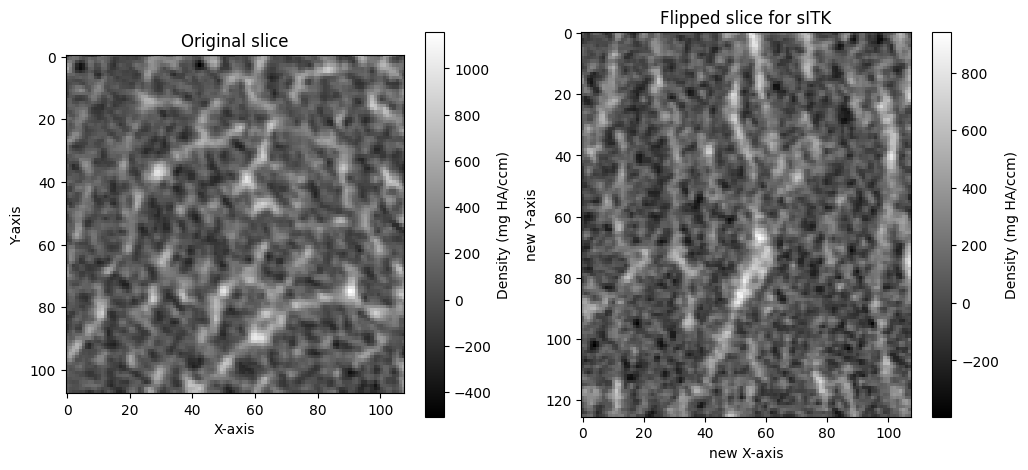

In [34]:
# Select the slice you want to visualize (you can change the index)
slice_index = 10
original_slice = np_image_density[:, :, slice_index]
flipped_slice = np_image_density_tp[:, :, slice_index]

# Plot the slices side by side using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Set labels and title
# Plot the slice using matplotlib
im1 = axs[0].imshow(original_slice, cmap='gray')
axs[0].set_title("Original slice")
axs[0].set_xlabel("X-axis")
axs[0].set_ylabel("Y-axis")
plt.colorbar(im1, ax=axs[0], label="Density (mg HA/ccm)")

im2 = axs[1].imshow(flipped_slice, cmap='gray')
axs[1].imshow(flipped_slice, cmap='gray')
axs[1].set_title("Flipped slice for sITK")
axs[1].set_xlabel("new X-axis")
axs[1].set_ylabel("new Y-axis")
plt.colorbar(im2, ax=axs[1], label="Density (mg HA/ccm)")

# Show the plot
plt.show()

### Convert numpy array to simpleITK

Now that the image is flipped to match with sITK formatting we can conver it from the numpy array to an sITK image object.

In [33]:
sitk_img = sitk.GetImageFromArray(np_image_density_tp)

### Add basic metadata to simpleITK

The numpy array carries no metadata information, so we need to explicitly include this if we want it in our sITK image object. 
<br><br>
Here an example is shown of how to pull origin and spacing (i.e. voxel size) using the vtkboneAIMReader member functions _GetOrigin()_ and _GetSpacing()_. These are the most commonly needed properties needed to correctly work with medical image data, but there may be more depending on your use case. 
<br><br>
These are taken from the vtk image object, then added to the sITK image object with the steps below

In [35]:
# show how sitk object has default spacing and origin
print("Default sitk origin in mm: ", sitk_img.GetOrigin())
print("Default sitk spacing (i.e. voxel size) in mm: ",sitk_img.GetSpacing())


Default sitk origin in mm:  (0.0, 0.0, 0.0)
Default sitk spacing (i.e. voxel size) in mm:  (1.0, 1.0, 1.0)


In [36]:
#get spacing and origin from vtk metadata 
img_origin = img_file.GetOrigin()
img_spacing = img_file.GetSpacing()

#set the spacing and origin in sitk metadata
sitk_img.SetOrigin(img_file.GetOrigin())
sitk_img.SetSpacing(img_file.GetSpacing())

print("Updated sitk origin in mm: ",img_file.GetOrigin())
print("Updated sitk spacing in mm: ",img_file.GetSpacing())

Updated sitk origin in mm:  (60.73000270687044, 45.43369018100202, 12.71633768081665)
Updated sitk spacing in mm:  (0.06069965288043022, 0.06069965288043022, 0.060698509216308594)


**NOTE**: See tutorial 3 and 4 for more extensive details on manipulating and storing the complete AIM header.

## Conclusion

From here you can proceed to perform more advanced image processing analysis with the sITK image object (or even the numpy array format itself). 
<br><br>
However, this notebook is rather inefficient and many intermediate images are created. So these steps are consolidated into a single helper function so you can switch directly from a raw AIM file to simpleITK image object. 

Details about running the function are as follows:
    
    Input:
        - file_path <str>: path to input aim
        - scaling <str>: unit of output image. Specify as "HU", "mu", "BMD" or "none"
        - WRITE_MHA <bool>: bool (TRUE/FALSE) to indicate whether or not to write the image as an mha-file.
        
    Output:
        - sitk_img: SimpleITK image class of aim image

Below is an example on how to run this function:

In [11]:
#load helper function
from python_helpers.aim_to_sitk import aim_to_sitk

#here we try a different bone sample
file_path = "data/TRAB_1237.AIM"
sitk_image = aim_to_sitk(file_path, "BMD", WRITE_MHA=False)

image converted to bone mineral density


Print some information to show it worked

In [22]:
img_array = sitk.GetArrayFromImage(sitk_image)
print("Mean density: ", np.mean(img_array))
print("Image dimensions: ", sitk_image.GetSize())

Mean density:  112.27903619612981
Image dimensions:  (108, 58, 49)


Make a simple plot of a 2D slice like before

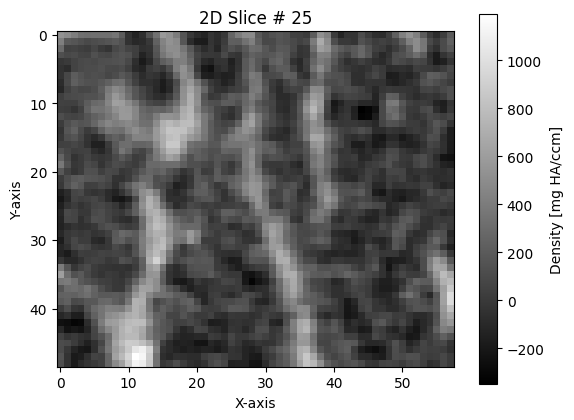

In [23]:
slice_index = 25
selected_slice = img_array[:, :, slice_index]

# Set labels and title
# Plot the slice using matplotlib
plt.imshow(selected_slice, cmap='gray')
plt.title(f"2D Slice # {slice_index}")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Density [mg HA/ccm]")
plt.show()

# Show the plot
plt.show()

From here you can do a lot more. Check out [**Tutorial 2**](02_visualization_and_img_processing_basics.ipynb) for how to perform core image processing steps and visualizations with your sITK image :) 